# **Diplomado IA: Aplicaciones de Inteligencia Artificial I - Parte 2**. <br> Práctico 22: Generación de resúmenes
---
---

**Profesores:**
- Felipe del Río

**Ayudante:**
- Bianca del Solar
---
---

# **Instrucciones Generales**

El siguiente práctico se debe realizar de forma **individual**. El formato de entregar es el **archivo .ipynb con todas las celdas ejecutadas**. Todas las preguntas deben ser respondida en celdas de texto. No se aceptará el _output_ de una celda de código como respuesta.

**Nombre:** Angelo Pimentel Quijano

El siguiente práctico cuanta con 3 secciones donde cada una contendrá 1 o más actividades a realizar. Algunas actividades correspondrán a escribir código y otras a responder preguntas.

Se recomienda **fuertemente** revisar las secciones donde se entrega código porque algunas actividades de código pueden reutilizar el mismo código pero con cambios en algunas líneas.



# **Agenda**

>[Diplomado IA: Aplicaciones de Inteligencia Artificial I - Parte 2.  Práctico 22: Generación de resúmenes](#scrollTo=tHopPtVaNF1K)

>[Instrucciones Generales](#scrollTo=uIdAKAdELPSl)

>[Agenda](#scrollTo=kEloa5uXLIPK)

>[Parte II: Generación de Resumenes Abstractivos ft. Huggingface's T5](#scrollTo=s-qQ_vAbhLY5)

>>[Preámbulo](#scrollTo=jFqmDr1T6mVq)

>>[Resumenes Abstractivos usando T5](#scrollTo=ThoicltP6yAe)

>>[Evaluación Cualitativa](#scrollTo=aH8JCHRcdzzS)

>>[Actividad 2](#scrollTo=98e-xDC87eG-)

>>[Actividad 3 - Parámetros de Decodificación](#scrollTo=Qi3RQ-OiX85A)

>>>[Número de Rayos de Beam Search](#scrollTo=9w4_w2LwaT_Y)

>>>>[num_beams=5](#scrollTo=KzJDRPBSakn3)

>>>>[num_beams=20](#scrollTo=nUj8fcVZar0Y)

>>>[Utilicemos aleatoriedad para samplear los resumenes](#scrollTo=Rko7cGwIblFi)

>>>>[do_sample=False](#scrollTo=ge4ySyZobdzx)

>>>>[do_sample=True](#scrollTo=C918sXK8bdzy)

>>>[Nucleus Sample](#scrollTo=zwBNqkcPcvzb)

>>>>[top_p=0.95](#scrollTo=bW__UwGqcvzc)

>>>>[top_p=0.9](#scrollTo=3JRdMHLBcvzc)

>>>[Temperatura](#scrollTo=oyQgEBdweQDT)

>>>>[temperature=0.6](#scrollTo=81ByEZsceQDU)

>>>>[temperature=1.5](#scrollTo=wXQBj5NseQDU)

>>[Evaluemos el Modelo](#scrollTo=w4DjPP9_Z4tC)

>>>[Dataset CNN/DailyMail](#scrollTo=ZXYQYRrafgA7)

>>>[Evaluación](#scrollTo=IK2C_8E_0KYB)

>>>[Inspección de Ejemplo](#scrollTo=y8yn_aVZ1EaM)

>>>[Evaluación Completa sobre CNN/DailyMail](#scrollTo=uuUxn7Jcguw9)

>>[Actividad 4](#scrollTo=LhPF_wGTiS32)



# Parte II: Generación de Resumenes Abstractivos ft. Huggingface's T5

<small>Agradecemos a Carlos Aspillaga por el código base para esta sección.</small>

En esta última secciónn veremos como se comporta un modelo abstractivo basado en Transformers, específicamente el [modelo T5](https://arxiv.org/pdf/1910.10683.pdf). Este modelo está basado en el transformer original (completo, no solo el encoder como BERT o decoder como GPT-X) el cual tiene un entrenamiento no supervisado en generación de texto basado en el de BERT. Y está pensado para luego ser especializado en una tarea relevante de generación, como generación de automática de resumenes, que posea menor cantidad de datos.

![1_D0J1gNQf8vrrUpKeyD8wPA.png](https://miro.medium.com/max/4006/1*D0J1gNQf8vrrUpKeyD8wPA.png)



## Preámbulo

Primero debemos descargar distintas utilidades para realizar la actividad.

Debemos importar algunas de las librerías que ocuparemos durante esta actividad, como `pytorch` y `transformers`.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Instalamos los paquetes a utilizar.
!pip install -qqq rouge-score
!pip install -qqq 'transformers[torch]'==4.45.2
!pip install -qqq datasets==3.0.1
!pip install -qqq evaluate==0.4.3
!pip install -qqq sentencepiece==0.1.99

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 19.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import json
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
from tqdm.auto import tqdm

In [3]:
import textwrap

# Funciones auxiliares para mostrar los resultados

def bold(text):
  return '\033[1m' + text + '\033[0m'

## Resumenes Abstractivos usando T5

A continuación utilizaremos un modelo pre-entranado que nos provee la librería `transformers` de hugginface y lo usaremos para generar resumenes.

Utilizaremos la versión *small* de este modelo. Tiene 60 millones de parámetros (vs. 220 millones en su versión *base* y 770 millones su versión *large*) y tanto el encoder y el decoder tienen los siguientes parámetros:
- $d_{model} = 512$
- $d_{ff} = 2,048$
- 8 heads
- 6 capas

In [4]:
t5_model = 't5-small' # Podríamos usar un modelo más grande, por e.g.: 't5-base'

device = torch.device('cuda')
model = T5ForConditionalGeneration.from_pretrained(t5_model).to(device)
tokenizer = T5Tokenizer.from_pretrained(t5_model)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Evaluación Cualitativa

Siempre es buena idea evaluar de forma cualitativa los modelos que entrenamos. Esto nos permite hacernos una intuición de cómo está funcionando y qué problemas puede tener.

En esta parte de la actividad la idea es probar el modelo utilizando noticias y/o textos de la "vida real". Así veamos cómo funcionaría el modelo en caso de que lo usasemos para una nueva aplicación.

In [ ]:
text ="""
The US has "passed the peak" on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.
At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors.
"We'll be the comeback kids, all of us," he said. "We want to get our country back."
The Trump administration has previously fixed May 1 as a possible date to reopen the world's largest economy, but the president said some states may be able to return to normalcy earlier than that.
"""

prefix = "summarize: "

preprocess_text = text.strip().replace("\n","")
t5_prepared_text = prefix + preprocess_text
print(bold("Texto Original:"))
print(textwrap.fill(text, width=70), end='\n\n')

Texto Original:
 The US has "passed the peak" on new coronavirus cases, President
Donald Trump said and predicted that some states would reopen this
month. The US has over 637,000 confirmed Covid-19 cases and over
30,826 deaths, the highest for any country in the world. At the daily
White House coronavirus briefing on Wednesday, Trump said new
guidelines to reopen the country would be announced on Thursday after
he speaks to governors. "We'll be the comeback kids, all of us," he
said. "We want to get our country back." The Trump administration has
previously fixed May 1 as a possible date to reopen the world's
largest economy, but the president said some states may be able to
return to normalcy earlier than that.



In [ ]:
NUM_SENTENCES = 5 # number of output summaries
NUM_BEAMS = 20 # must be >= NUM_SENTENCES

tokenized_text = tokenizer.encode(t5_prepared_text, return_tensors="pt").to(device)

# summmarize
summary_ids = model.generate(tokenized_text,
                             num_beams=NUM_BEAMS,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

tokenized_text = None # Free GPU memory

Texto resumido: 

Resumen 0:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that.

Resumen 1:
the us has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that.

Resumen 2:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president said some states
may be able to return to normalcy earlier than that.

Resumen 3:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that. "we want to get
our country back," he says.

Resumen 4:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the p

## Actividad 2

1. Busque una noticia reciente (en inglés) y genere un resumen abstractivo en base a esta.

**Importante:** Preocupese de que el texto no sea tan largo que el procesamiento no quepa en la GPU.

In [ ]:
my_news = """
UFC heavyweight champion Jon Jones has announced his return to the Octagon after nearly two years away. Jones will face interim champion Tom Aspinall at UFC 312 this December in Las Vegas. The fight will mark Jones’s first title defense since winning the belt in 2023. During an interview, Jones said he feels “stronger than ever” and is focused on proving he remains the best fighter in the world. Aspinall, meanwhile, believes his speed and youth will be key to defeating Jones. UFC president Dana White called the bout “a massive event for the division” and said fans should expect one of the greatest heavyweight clashes in years.
"""

preprocess_text = my_news.strip().replace("\n","")
t5_prepared_Text = "summarize: " + preprocess_text
print(bold("Texto Original:"))
print(textwrap.fill(my_news, width=70), end='\n\n')

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)

NUM_SENTENCES = 5 # number of output summaries
NUM_BEAMS = 20 # must be >= NUM_SENTENCES

# summmarize
summary_ids = model.generate(tokenized_text,
                             num_beams=NUM_BEAMS,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

tokenized_text = None # Free GPU memory

Texto Original:
 UFC heavyweight champion Jon Jones has announced his return to the
Octagon after nearly two years away. Jones will face interim champion
Tom Aspinall at UFC 312 this December in Las Vegas. The fight will
mark Jones’s first title defense since winning the belt in 2023.
During an interview, Jones said he feels “stronger than ever” and is
focused on proving he remains the best fighter in the world. Aspinall,
meanwhile, believes his speed and youth will be key to defeating
Jones. UFC president Dana White called the bout “a massive event for
the division” and said fans should expect one of the greatest
heavyweight clashes in years.

Texto resumido: 

Resumen 0:
the fight will mark Jones’s first title defense since winning the belt
in 2023. interim champion Tom Aspinall believes his speed and youth
will be key to defeating Jones.

Resumen 1:
the bout will mark Jones’s first title defense since winning the belt
in 2023. interim champion Tom Aspinall believes his speed and you

2. En base a la noticia anterior y los candidatos a resumenes generados, conteste las siguientes preguntas.

In [ ]:
#@title ¿Con cuál de los candidatos generados se quedaría como resumen final? Justifica brevemente.
R = "Me quedaría con el Resumen 2, es mas completo e incluye la información central (la primera defensa del título de Jones y la confianza de Aspinall en vencerlo), además de un elemento adicional importante para el contexto (Declaración de Dana White), lo que da mas sentido general de la noticia." #@param {type:"string"}


In [ ]:
#@title De los mecanismos vistos en clases nombre **uno** para aumentar la diversidad de los candidatos generados por el modelo.
R = "Elegir las frases que maximizan la métrica ROUGE respecto al resumen gold standard, ya que indica cuáles oraciones representan mejor el contenido esencial del texto original." #@param {type:"string"}


3. Elija dos o tres párrafos de un libro a su elección (en inglés), y genere un resumen en base este utilizando el código a continuación.

**Importante:** Preocupese de que el texto no sea tan largo que el procesamiento no quepa en la GPU.

In [5]:
other_text = """
I wish to preach, not the doctrine of ignoble ease, but the doctrine of the
strenuous life, the life of toil and effort, of labor and strife; to preach
that highest form of success which comes, not to the man who desires mere
easy peace, but to the man who does not shrink from danger, from hardship,
or from bitter toil, and who out of these wins the splendid ultimate triumph.

A life of slothful ease, a life of that peace which springs merely from lack
either of desire or of power to strive after great things, is as little
worthy of a nation as of an individual. I ask only that what every
self-respecting American demands from himself and from his sons shall be
demanded of the American nation as a whole.

I preach to you, then, my countrymen, that our country calls not for the
life of ease but for the life of strenuous endeavor. If we stand idly by,
if we seek merely swollen, slothful ease and ignoble peace, if we shrink
from the hard contests where men must win at hazard of their lives and at
the risk of all they hold dear, then the bolder and stronger peoples will
pass us by, and will win for themselves the domination of the world.
"""


preprocess_text = other_text.strip().replace("\n","")
t5_prepared_Text = "summarize: " + preprocess_text
print(bold("Texto Original:"))
print(textwrap.fill(other_text, width=70), end='\n\n')

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)

NUM_SENTENCES = 5 # number of output summaries
NUM_BEAMS = 20 # must be >= NUM_SENTENCES

# summmarize
summary_ids = model.generate(tokenized_text,
                             num_beams=NUM_BEAMS,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

tokenized_text = None # Free GPU memory

Texto Original:
 I wish to preach, not the doctrine of ignoble ease, but the doctrine
of the strenuous life, the life of toil and effort, of labor and
strife; to preach that highest form of success which comes, not to the
man who desires mere easy peace, but to the man who does not shrink
from danger, from hardship, or from bitter toil, and who out of these
wins the splendid ultimate triumph.  A life of slothful ease, a life
of that peace which springs merely from lack either of desire or of
power to strive after great things, is as little worthy of a nation as
of an individual. I ask only that what every self-respecting American
demands from himself and from his sons shall be demanded of the
American nation as a whole.  I preach to you, then, my countrymen,
that our country calls not for the life of ease but for the life of
strenuous endeavor. If we stand idly by, if we seek merely swollen,
slothful ease and ignoble peace, if we shrink from the hard contests
where men must win at haza

Responda las siguientes preguntas en base al texto elegido y los resumenes generados para este.

In [ ]:
#@title Indique el libro que eligió.
R = "The Strenuous Life — Theodore Roosevelt (1899; recopilado en 'The Strenuous Life: Essays and Addresses', 1901)\"" #@param {type:"string"}


In [ ]:
#@title ¿Con cuál de los candidatos generados se quedaría como resumen final?
R = "Resumen 0, concentra de mejor manera a la idea principal del texto del libro, sin embargo los candidatos tienen resultados similares." #@param {type:"string"}


In [ ]:
#@title ¿Cómo se compara la calidad del resumen en comparación al obtenido utilizando una noticia?
R = "En comparación, el resumen del libro es mas interpretativo por su lenguaje abstracto, mientras que el de la noticia resulta mas claro y preciso, con hechos esenciales, con una estructura sencilla que facilita al modelo identificar ideas principales." #@param {type:"string"}


In [ ]:
#@title Proponga **una** medida para mejorar la calidad del resumen obtenido.
R = "Una medida seria entrenar o ajustar el modelo (fine-tuning) con textos del mismo tipo en este caso (autobiografías),para que aprenda estilo y estructura, de esta forma el modelo entendería mejor los matices del lenguaje reflexivo y generaría resúmenes más coherentes y consecuentes con la idea principal." #@param {type:"string"}


## Actividad 3 - Parámetros de Decodificación

Exploremos ahora cómo distintos parámetros de decodificación afectan la generación de texto del modelo. Utilizaremos la misma noticia de la actividad anterior para esto, de manera de entender mejor los efectos de cada uno.

Como vimos en clase veremos el efecto de modificar los siguientes parámetros del método `generate` del modelo:
- Número de 'rayos' de beam search, `num_beams`.
- Samplear (en vez de decodificación greedy), `do_sample`.
- Hacer nucleus sample, `top_p`.
- Temperatura, `temperature`.

**Actividad:** Despues de cada parámetro de modificación analice brevemente que cambios observa entre ambos ejemplos generados.

Veamos nuevamente la noticia que estamos utilizando, y generemos resumenes alterando un parámetro a la vez. Seguiremos mostrando 5 resultados de manera de ver la diferencia entre ellos.

In [6]:
text ="""
The US has "passed the peak" on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.
At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors.
"We'll be the comeback kids, all of us," he said. "We want to get our country back."
The Trump administration has previously fixed May 1 as a possible date to reopen the world's largest economy, but the president said some states may be able to return to normalcy earlier than that.
"""

prefix = "summarize: "

preprocess_text = text.strip().replace("\n","")
t5_prepared_text = prefix + preprocess_text
print(bold("Texto Original:"))
print(textwrap.fill(text, width=70), end='\n\n')

tokenized_text = tokenizer.encode(t5_prepared_text, return_tensors="pt").to(device)

Texto Original:
 The US has "passed the peak" on new coronavirus cases, President
Donald Trump said and predicted that some states would reopen this
month. The US has over 637,000 confirmed Covid-19 cases and over
30,826 deaths, the highest for any country in the world. At the daily
White House coronavirus briefing on Wednesday, Trump said new
guidelines to reopen the country would be announced on Thursday after
he speaks to governors. "We'll be the comeback kids, all of us," he
said. "We want to get our country back." The Trump administration has
previously fixed May 1 as a possible date to reopen the world's
largest economy, but the president said some states may be able to
return to normalcy earlier than that.



### Número de Rayos de Beam Search

Para esto modificamos el parámetro `num_beams`.

#### `num_beams=5`

In [7]:
summary_ids = model.generate(tokenized_text,
                             num_beams=5,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
says.

Resumen 1:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
said.

Resumen 2:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world.

Resumen 3:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and 30,826 deaths, the highest for
any country in the world.

Resumen 4:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. he sa

#### `num_beams=20`

In [8]:
summary_ids = model.generate(tokenized_text,
                             num_beams=20,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that.

Resumen 1:
the us has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that.

Resumen 2:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president said some states
may be able to return to normalcy earlier than that.

Resumen 3:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that. "we want to get
our country back," he says.

Resumen 4:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the p

In [ ]:
#@title Analice brevemente la diferencia entre ambos textos generados.
R = "Num_beams=5 resumen es mas rápido pero menos preciso y variado, con menos opciones, mientras tanto Num_beams=20 evalúa mas opciones de resúmenes, generando texto mas coherente con el contexto, completo, aunque tarda mas tiempo en procesar. " #@param {type:"string"}


### Utilicemos aleatoriedad para samplear los resumenes

Para esto modificamos el parámetro `do_sample`. Esto significa que en cada paso de deocidificación no nos quedaremos solamente con el token más probable, si no que eligiremos uno aleatoriamente dependiendo de las probabilidades de salida del modelo. Para los siguientes parámetros mantrendremos esta propiedad.

#### `do_sample=False`

In [9]:
summary_ids = model.generate(tokenized_text,
                             do_sample=False,
                             num_beams=5,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
says.

Resumen 1:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
said.

Resumen 2:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world.

Resumen 3:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and 30,826 deaths, the highest for
any country in the world.

Resumen 4:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. he sa

#### `do_sample=True`

In [10]:
summary_ids = model.generate(tokenized_text,
                             do_sample=True,
                             num_beams=5,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the president predicts some states will reopen this month. the country
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we'll be the comeback kids, all of us,"
he says.

Resumen 1:
the president predicts some states will reopen this month. the country
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we'll be the comeback kids, all of us,"
he said.

Resumen 2:
the president predicts some states will reopen this month. the country
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
says.

Resumen 3:
the president predicts some states will reopen this month. the country
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we'll be the comeback kids," he says.

Resumen 4:
the president predicts some states will reopen this month. t

In [ ]:
#@title Analice brevemente la diferencia entre ambos textos generados.
R = "Do_sample=False El resumen es mas preciso y repetitivo buscando la respuesta mas probable Do_sample=True es mas variado y creativo, pero menos exacto." #@param {type:"string"}

### Nucleus Sample

Para esto modificamos el parámetro `top_p`. Este parámetro modifica la cantidad de elementos dentro de los que samplearemos, así no considerar toda la distribución. Debe cumplir `0 <= top_p <= 1`.

#### `top_p=0.95`

In [11]:
summary_ids = model.generate(tokenized_text,
                             do_sample=True,
                             top_p=0.95,
                             num_beams=5,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
says.

Resumen 1:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
said.

Resumen 2:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world.

Resumen 3:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and 30,826 deaths, the highest for
any country in the world.

Resumen 4:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we w

#### `top_p=0.9`

In [12]:
summary_ids = model.generate(tokenized_text,
                             do_sample=True,
                             top_p=0.9,
                             num_beams=20,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that.

Resumen 1:
the us has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that.

Resumen 2:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president said some states
may be able to return to normalcy earlier than that.

Resumen 3:
the us has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that. "we want to get
our country back," he says.

Resumen 4:
the us has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the presi

In [ ]:
#@title Analice brevemente la diferencia entre ambos textos generados.
R = "Top_p=0.95 resumen mas completo y cercano al texto original Top_p=0.9 mas breve y conservador, reduciendo la variedad de palabras y posibles expresiones." #@param {type:"string"}

### Temperatura

Para esto modificamos el parámetro `temperature`. Este parámetro modifica la distribución misma de la que samplearemos los tokens. Una temperatura menor a 1 (`temperature < 1`), hará que haya menos variabilidad en la distribución. Mientras que mayor a 1 (`temperature > 1`) hará que haya más variabilidad, por ende sea más diversa.

#### `temperature=0.6`

In [13]:
summary_ids = model.generate(tokenized_text,
                             do_sample=True,
                             temperature=0.6,
                             num_beams=5,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
says.

Resumen 1:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. "we want to get our country back," he
said.

Resumen 2:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world.

Resumen 3:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and 30,826 deaths, the highest for
any country in the world.

Resumen 4:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths, the highest
for any country in the world. he sa

#### `temperature=1.5`

In [14]:
summary_ids = model.generate(tokenized_text,
                             do_sample=True,
                             temperature=1.5,
                             num_beams=20,
                             no_repeat_ngram_size=2,
                             num_return_sequences=NUM_SENTENCES,
                             min_length=30,
                             max_length=100,
                             early_stopping=True).cpu()

print(bold("Texto resumido: \n"))
for i, beam_output in enumerate(summary_ids):
  output = tokenizer.decode(beam_output, skip_special_tokens=True)
  print(bold(f"Resumen {i}:"))
  print(textwrap.fill(output, width=70), end='\n\n')

Texto resumido: 

Resumen 0:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that.

Resumen 1:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy sooner than that.

Resumen 2:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president predicts some
states will reopen this month.

Resumen 3:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in the world. the president says some states
may be able to return to normalcy earlier than that. he has previously
fixed May 1 as a possible date to reopen world's largest economy.

Resumen 4:
the u.s. has over 637,000 confirmed cases and over 30,826 deaths, the
highest for any country in 

In [ ]:
#@title Analice brevemente la diferencia entre ambos textos generados.
R = "Temperature=0.6 el modelo genera resúmenes más precisos y similares entre sí. Temperature=1.5, aumenta la creatividad y diversidad , agregando nuevas frases y variaciones en el contenido." #@param {type:"string"}

In [ ]:
# @title ¿Cúal fue el cambio de parámetro que pudo notar mayor diversidad?
R = "El cambio donde noté mas diversidad fue aumentando la temperatura, debido a que hace que el modelo explore más posibilidades al elegir las palabras." # @param {"type":"string"}


In [15]:
tokenized_text = None # Free GPU memory

## Evaluemos el Modelo

Ya teniendo una mejor idea de las capacidades del modelo T5, evaluemosló cuantitativamente utilizando la métrica ROUGE.

Esto nos permitirá tener información más general de como funciona el modelo sobre un set de datos completo.

Para esto utilizaremos el set de test del dataset CNN/DailyMail. Utilizaremos la librería `datasets` que también nos provee huggingface para acceder a los datos.

### Dataset CNN/DailyMail

Primero que todo carguemos los datos de este dataset con la ayuda del paquete `datasets` de huggingface. Para esto utilizamos la función `load_dataset` que nos provee para hacerlo de forma simple.

In [16]:
from datasets import load_dataset

cnndm = load_dataset("abisee/cnn_dailymail", "3.0.0", split="test")

README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

También hagamos un pequeño análizis de los datos. Específicamente nos interesa saber la distribución de los largos de los textos, tanto de los artículos como de los resumenes. Esto nos permitirá setear de mejor manera ls parámetros de evaluación.

In [17]:
article_tokenized_len = [len(tokenizer.encode(ex)) for ex in cnndm['article']]
summary_tokenized_len = [len(tokenizer.encode(ex)) for ex in cnndm['highlights']]

Token indices sequence length is longer than the specified maximum sequence length for this model (787 > 512). Running this sequence through the model will result in indexing errors


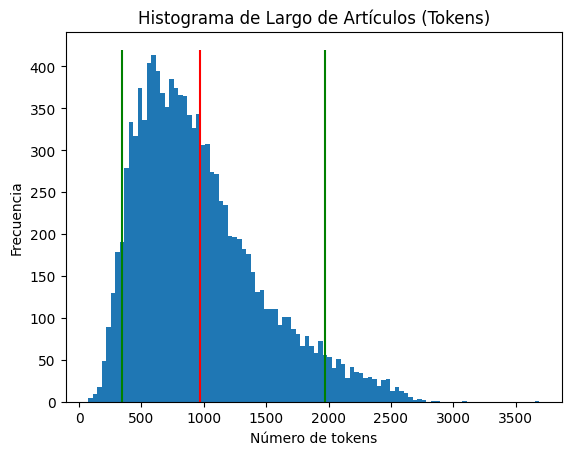

In [18]:
plt.hist(article_tokenized_len, bins=100)
plt.vlines(np.percentile(article_tokenized_len, 5), 0, 420, color='green')
plt.vlines(np.mean(article_tokenized_len), 0, 420, color='red')
plt.vlines(np.percentile(article_tokenized_len, 95), 0, 420, color='green')
plt.xlabel('Número de tokens')
plt.ylabel('Frecuencia')
plt.title('Histograma de Largo de Artículos (Tokens)')
plt.show()

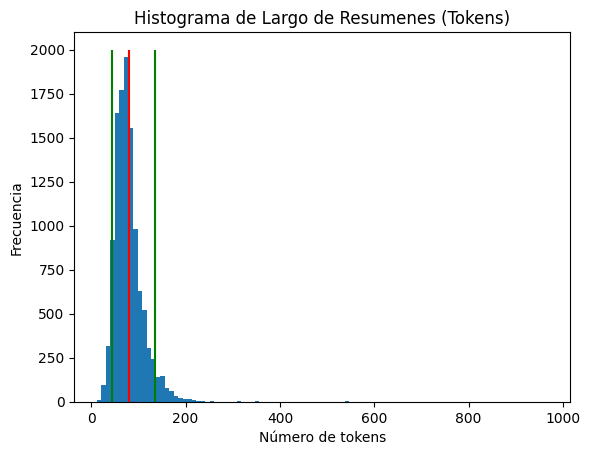

In [19]:
plt.hist(summary_tokenized_len, bins=100)
plt.vlines(np.percentile(summary_tokenized_len, 5), 0, 2000, color='green')
plt.vlines(np.mean(summary_tokenized_len), 0, 2000, color='red')
plt.vlines(np.percentile(summary_tokenized_len, 95), 0, 2000, color='green')
plt.xlabel('Número de tokens')
plt.ylabel('Frecuencia')
plt.title('Histograma de Largo de Resumenes (Tokens)')
plt.show()

In [20]:
print(bold('Largos de Artículos'))
print(f'percentil 1:  {np.percentile(article_tokenized_len, 1):5.1f}')
print(f'percentil 5:  {np.percentile(article_tokenized_len, 5):5.1f}')
print(f'promedio:     {np.mean(article_tokenized_len):5.1f}')
print(f'percentil 95: {np.percentile(article_tokenized_len, 95):5.1f}')
print(f'percentil 99: {np.percentile(article_tokenized_len, 99):5.1f}')
print()
print(bold('Largos de Resumenes'))
print(f'percentil 1:  {np.percentile(summary_tokenized_len, 1):5.1f}')
print(f'percentil 5:  {np.percentile(summary_tokenized_len, 5):5.1f}')
print(f'promedio:     {np.mean(summary_tokenized_len):5.1f}')
print(f'percentil 95: {np.percentile(summary_tokenized_len, 95):5.1f}')
print(f'percentil 99: {np.percentile(summary_tokenized_len, 99):5.1f}')

Largos de Artículos
percentil 1:  236.7
percentil 5:  345.0
promedio:     969.3
percentil 95: 1974.0
percentil 99: 2436.0

Largos de Resumenes
percentil 1:   32.0
percentil 5:   44.0
promedio:      79.3
percentil 95: 135.0
percentil 99: 174.0


### Evaluación

Empecemos a desarrollar nuestra evaluación. Utilizando la información de las distribuciones de los resumenes elegimos los mejores parámetros para evaluar en nuestro problema.

In [21]:
eval_min_length = 32
eval_max_length = 135
eval_article_max_length = 768

eval_num_beams = 1
eval_batch_size = 128

También, creamos el objeto que nos ayudará a calcular los valores de ROUGE. Nuevamente utilizaremos un paquete que nos provee huggingface para esto, en este caso se llama `evaluate` y nos provee muchas de las métricas que se utilizan en machine learning.

In [25]:
import evaluate

rouge = evaluate.load("rouge")
rouge_types = ['rouge1', 'rouge2', 'rougeL']

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels,
                           rouge_types=rouge_types, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

def print_rouges(pred, tgt):
    labels = tokenizer(text_target=[random_summary], max_length=eval_max_length, truncation=True)
    scores = compute_metrics((pred, tgt))
    for score_type in rouge_types:
        score = scores[score_type]
        print(f'{score_type:6.6}: {score:.4f}')

### Inspección de Ejemplo

Inspeccionemos un ejemplo del dataset en el que vamos a evaluar y calculemos el ROUGE score sobre este. Nos permitirá entender mejor el tipo de ejemplos que existen en el dataset y hacernos una idea de como funciona el ROUGE score de manera más específica.

In [26]:
dataset_len = len(cnndm)
rand_idx = random.randint(0, dataset_len)
random_article = cnndm['article'][rand_idx]
random_summary = cnndm['highlights'][rand_idx]

In [27]:
prefix = "summarize: "
preprocess_text = random_article.strip().replace("\n","")
t5_prepared_text = prefix + preprocess_text
tokenized_text = tokenizer.encode(t5_prepared_text, return_tensors="pt").to(device)
target = tokenizer(text_target=[random_summary], max_length=eval_max_length, truncation=True)['input_ids']

summary_ids = model.generate(tokenized_text,
                             num_beams=20,
                             no_repeat_ngram_size=2,
                             num_return_sequences=1,
                             min_length=eval_min_length,
                             max_length=eval_max_length,
                             early_stopping=True).cpu()
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# pred = summary_ids.cpu()
tokenized_text = None # Free GPU memory

In [28]:
print(bold("Texto Original:"))
print(textwrap.fill(random_article, width=80), end='\n\n')
print(bold("Resumen Gold Standard:"))
print(textwrap.fill(random_summary, width=80), end='\n\n')
print(bold("Resumen Generado:"))
print(textwrap.fill(output, width=80), end='\n\n')
print(bold("ROUGE Scores:"))
print_rouges(summary_ids, target)

Texto Original:
Of all the people to be wary of getting caught on camera doing something
incredulous, you would think a TV news reporter would know better. But Britt
McHenry, a Washington D.C.-based sports reporter for ESPN, has been suspended
from her position after an ugly and offensive rant she unleashed on a hapless
tow truck company employee surfaced online this week. The 28-year-old, who hails
from New Jersey, had her car towed from the parking lot of a Chinese restaurant
in Arlington, Virginia, and the verbal attack was captured on a security camera
as she paid to pick the vehicle up at the tow lot office. 'I’m in the news,
sweetheart, I will f-----g sue this place,' McHenry can he heard saying in the
video. Vicious: ESPN sports reporter Britt McHenry has been suspended for one
week and could face further punishment after video surfaced of her berating an
Advanced Towing employee in Arlington, Virginia . Caught red-faced: Incredibly,
McHenry was warned that she was being filmed 

### Evaluación Completa sobre CNN/DailyMail

Finalemente efectuemos la evaluación sobre todo el set de test.

Dado que el dataset original contiene texto, es necesario primero tokenizar ese texto de manera de tener valores numéricos que nuestro modelo pueda procesar. Para eso lo primero es preprocesar el dataset, generamos una función con este fin: `preprocess_function`.

In [29]:
def preprocess_function(examples):
    inputs = [prefix + doc.strip().replace("\n","") for doc in examples["article"]]
    model_inputs = tokenizer(
        inputs, max_length=eval_article_max_length, truncation=True)

    labels = tokenizer(
        text_target=examples["highlights"], max_length=eval_max_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Efectuamos el preprocesamiento y creamos un `DataLoader` que nos permita iterar de forma eficientemente sobre los datos.

In [30]:
from transformers import DataCollatorForSeq2Seq
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

tokenized_cnndm = cnndm.map(preprocess_function, batched=True)
tokenized_cnndm = tokenized_cnndm.remove_columns(cnndm.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=t5_model)

loader = DataLoader(tokenized_cnndm, batch_size=eval_batch_size,
                    collate_fn=data_collator, shuffle=True, num_workers=cores,
                    pin_memory=True)

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

Finalmente haremos la evaluación.

In [31]:
model.eval()

all_predictions = []
all_labels = []

for batch in tqdm(loader):
    inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
    labels = batch['labels'].to(device)

    with torch.no_grad():
        generated_tokens = model.generate(
            **inputs,
            max_length=eval_max_length,
            num_beams=eval_num_beams,
            no_repeat_ngram_size=2,
            early_stopping=True,
        )

    all_predictions.extend(generated_tokens.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

all_predictions = np.stack(all_predictions)
all_labels = np.stack(all_labels)

rouge_results = compute_metrics((all_predictions, all_labels))

  0%|          | 0/90 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


E imprimimos el resultado de los distintos scores de ROUGE en nuestro dataset:

In [32]:
print(bold("ROUGE Scores promedio:"))
for score_type in rouge_types:
    score = rouge_results[score_type]
    print(f'{score_type:6.6}: {score:.4f}')

ROUGE Scores promedio:
rouge1: 0.3488
rouge2: 0.1312
rougeL: 0.2266


## Actividad 4

En el trabajo en que propusieron y probaron T5 ellos reportan los siguientes resultados en este dataset:

**ROUGE-1 :**   41.12

**ROUGE-2 :**   19.56

**ROUGE-L :**   38.35

In [ ]:
# @title ¿Por qué nuestro model no alcanzó el mismo rendimento de ROUGE que el reportado en el trabajo original? De *dos razones* concretas.
R1 = "Debido a que se utilizó una versión más pequeña y menos entrenada del modelo T5 que la empleada en el trabajo original." # @param {"type":"string"}
R2= "El preprocesamiento del texto y la decodificación fueron más simples, lo que redujo la calidad de los resúmenes generados." # @param {"type":"string"}


In [ ]:
# @title Proponga una mejora a lo que hicimos en el laboratorio para mejorar el rendimiento. Esta no debe considerar modificar ninguno de los parámetros que hemos utilzado acá. Responda brevemente:
M = "Aplicar una etapa previa de selección de oraciones mas relevantes (extract-then-abstract) antes del resumen para reducir ruido y mejorar la naturalidad, coherencia y exactitud del resultado." # @param {"type":"string"}